## The dangers of fitting computational models to individual subjects with few observations

---

**Note**: I wrote this document a while ago to illustrate an issue in fitting computational models to individual subjects, rather than the overall group, when dealing with few observations. Aside from that, it serves well to illustrate two additional topics - 1) how to extract information from model objects (e.g., lm, glm, etc) and 2) how to use tidyverse to automatically run the same model over multiple groups and to extract the results.

---

I work with computational models. Today I was confused by the behavior of my model, and I finally figured out that in this case *fitting the model to individual subjects was the wrong thing to do*. In fitting computational models, you typically have the choice to either fit the overall data, ignoring by-subject variation, or to fit a separate model to each subject. Many authors recommend the latter, when possible, and for good reasons. However, fitting individual subjects can be problematic, as in this case. 

I know my model. I know that for this dataset conceptually it should be able to fit a nice logistic function as in the figure below, which the data showed. When I saw the data I was really excited; however, after I fit the model, suddenly it predicted almost a linear function.

![image.png](https://i.imgur.com/dXoYbtr.png)

### The problem

I was confused. Why is the model behaving like this, when I know it should be able to fit the shape shown above? Turns out, this is a type of overfitting bias when attemtping to fit individual subjects. This case is quite interesting, because overfitting can actually lead to a worse fit of the training data itself. Overfitting problems with generalization are well known, but typically overfitting at least fits well to the data used to train the model. 

As it turns out, overfitting can lead to worse results when it *overfits selectively*. I'll elaborate.

The model in question is a mechanistic memory model with many parameters and complex implementation and is not actually fitting a logistic curve, but for the current purposes I will show a simplified example.

### A simulation

Suppose that you observe the following logistic growth behavior of *y* as a function of *x*. In my case, y was probability of recall, but it doesn't really matter.

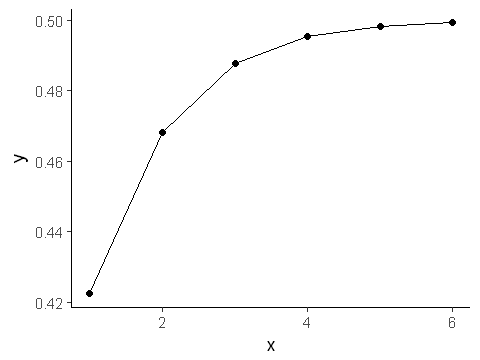

In [2]:
library(tidyverse, quietly=TRUE)
options(repr.plot.width=4, repr.plot.height=3, warn=-1)
library(IRdisplay, quietly=TRUE)

# prep the data
x = c(1,2,3,4,5,6)
y = 1/(2 + exp(-x))
df = data.frame(x=x,y=y)

# plot the data
ggplot(df, aes(x,y)) +
    geom_point() +
    geom_line() +
    theme_classic()

Now, let's generate data for some subjects. Each observation is a 1 or a 0 with a probability determined by the underlying model plotted above. One key issue is that we are dealing with relatively little observations per subject (90 overall, 15 per condition), which, however, is not atypical for memory and cognitive experiments.


In [3]:
# function for generating data
draw_samples <- function(p, n) {
    samples = sample(c(0,1), prob=c(1-p, p), size=n, replace=T)
    prop = mean(samples)
    return(prop)    
}

# replicate the dataframe for each subject
set.seed(1212276)
nSubj = 1000
df$nObs = c(15, 15, 15, 15, 15, 15)
data <- df[rep(1:nrow(df), nSubj),]
data$subject <- rep(1:nSubj, each=nrow(df))

# generate data for each subject
data <- data  %>% 
    group_by(x, subject)  %>% 
    mutate(obs = draw_samples(y, nObs))

head(data, n=10)

x,y,nObs,subject,obs
1,0.4223188,15,1,0.3333333
2,0.4683105,15,1,0.3333333
3,0.4878556,15,1,0.5333333
4,0.4954626,15,1,0.2666667
5,0.4983212,15,1,0.5333333
6,0.4993811,15,1,0.2666667
1,0.4223188,15,2,0.4666667
2,0.4683105,15,2,0.3333333
3,0.4878556,15,2,0.4000000
4,0.4954626,15,2,0.5333333


Ok, so we have plenty of variation in our subjects. Let's plot the generated data against the underlying model

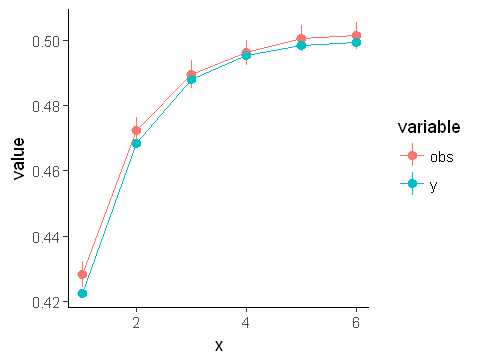

In [4]:
data  %>% 
    gather(variable, value, y, obs)  %>% 
    ggplot(aes(x, value, color=variable)) +
    stat_summary(fun.data=mean_se) +
    stat_summary(fun.data=mean_se,geom='line') +
    theme_classic()

And let's plot a couple of subject just to show their variation:

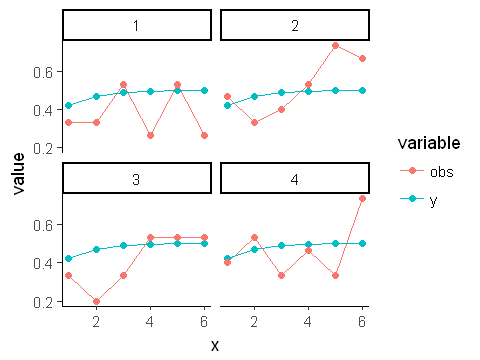

In [5]:
data  %>% 
    gather(variable, value, y, obs)  %>% 
    filter(subject <= 4)  %>% 
    ggplot(aes(x, value, color=variable)) +
    geom_point() +
    geom_line() +
    facet_wrap(~subject) +
    theme_classic()

As expected, since we have few observations, each subject is a poor representation of the overall data, yet, the average reflects it well. Now, for the interesting part. Let us try to fit an logistic growth model to:
1. The overall sample
2. Each subject individually

### Fitting the overall sample

In [6]:
# Logistic function
myPredict <- function(par, x) {
    pred = par[1]/(par[2] + exp(-par[3]*x))
    return(pred)
}

# Calculate error for minimazation
errorFunction <- function(par, obs, x) {
    predicted = myPredict(par, x)
    error = sqrt(mean((obs-predicted) ** 2))
    return(error)
}

# Fit the model and extract predictions
overall.fit <- optim(c(1,1,1), errorFunction, obs=data$obs, x=data$x)
data$overall.pred <- myPredict(overall.fit$par, data$x)
print(overall.fit$par)


[1] 1.0958580 2.1848688 0.9864729


Alright, we see a pretty good fit and recovery of the original model:

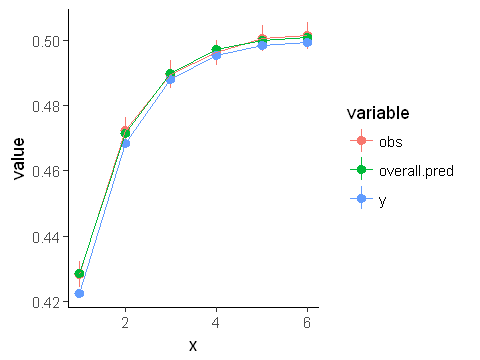

In [7]:
data  %>% 
    gather(variable, value, y, obs, overall.pred)   %>% 
    ggplot(aes(x, value, color=variable)) +
    stat_summary(fun.data=mean_se) +
    stat_summary(fun.data=mean_se, geom='line') +
    theme_classic()

### Fitting individual subjects

Let's see how fitting the individual subjects will fare.

In [8]:
# Fit parameters of the logistic function for every subject and extract them
fittedPars <- data  %>% 
    group_by(subject)  %>% 
    nest(-subject)  %>%
    mutate(fit = map(data, ~ try(optim(par=c(1,1.5,1), fn = errorFunction, obs = .$obs, x=.$x))),
           pars = map(fit, ~ .$par))  %>% 
    select(-fit)

# Get final predictions for each subject
fitted <- fittedPars  %>% 
    mutate(subjectPred = map2(data, pars, ~ myPredict(.y, .x$x)))  %>% 
    unnest(data, subjectPred)

head(fitted, n=10)

subject,subjectPred,x,y,nObs,obs,overall.pred
1,0.3283832,1,0.4223188,15,0.3333333,0.4284447
1,0.3779846,2,0.4683105,15,0.3333333,0.4715567
1,0.3884094,3,0.4878556,15,0.5333333,0.4899402
1,0.3903222,4,0.4954626,15,0.2666667,0.4971675
1,0.3906641,5,0.4983212,15,0.5333333,0.4999174
1,0.3907249,6,0.4993811,15,0.2666667,0.5009506
2,0.3729196,1,0.4223188,15,0.4666667,0.4284447
2,0.4181209,2,0.4683105,15,0.3333333,0.4715567
2,0.4718946,3,0.4878556,15,0.4000000,0.4899402
2,0.5367985,4,0.4954626,15,0.5333333,0.4971675


We've fit a logistic growth model to each subject, let's plot the overall fit:

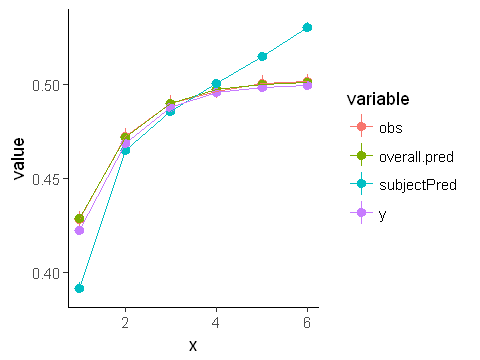

In [9]:
fitted  %>% 
    gather(variable, value, y, obs, overall.pred, subjectPred)   %>% 
    ggplot(aes(x, value, color=variable)) +
    stat_summary(fun.data=mean_se) +
    stat_summary(fun.data=mean_se, geom='line') +
    theme_classic()

Surprise! Fitting the model to each subject makes very different predictions and it overpredicts probabilities at the higher values of X where the underlying logistic model levels off. Why does that happen? To understand it, let's plot the fit to several subjects.

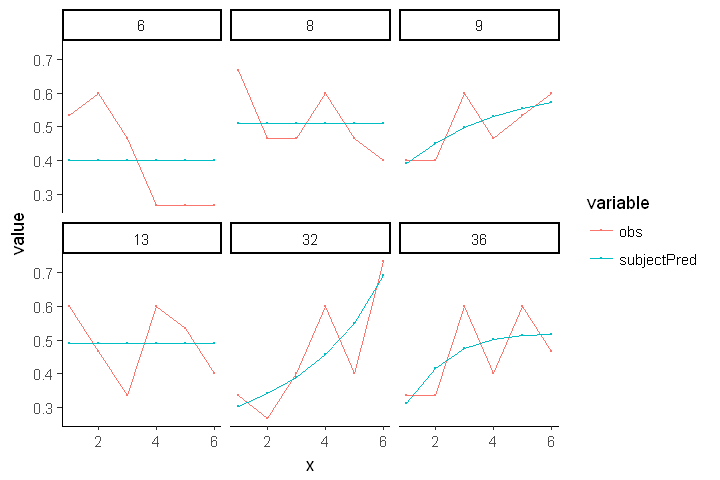

In [10]:
options(repr.plot.width=6, repr.plot.height=4)
fitted  %>% 
    filter(subject %in% c(8, 6, 13, 32, 36, 9))  %>% 
    gather(variable, value, obs, subjectPred)   %>% 
    ggplot(aes(x, value, color=variable)) +
    geom_point(size=0.2) +
    geom_line() +
    theme_classic() +
    facet_wrap(~subject)

Can you see it? These subjects represent two classes - those that show generally increasing or decreasing *value* with *x*. We have both due to the random sampling, which introduces noise. The logistic growth model, however, can only fit an increasing function, and it does that for subjects 9, 32 and 36. Subject 36 and 9 show similar to the original pattern; however, Subject 32 shows a much more extreme slope. And while the model can overfit subject like 32, it fails with subjects like 6, 8 and 13 and is in essence biased. For those three subjects, the best thing it can do to minimize the error is to fit a flat function. Indeed, if we calculate for each subject the error at each value of x, we cna see clearly that the error is biased at the extremes:

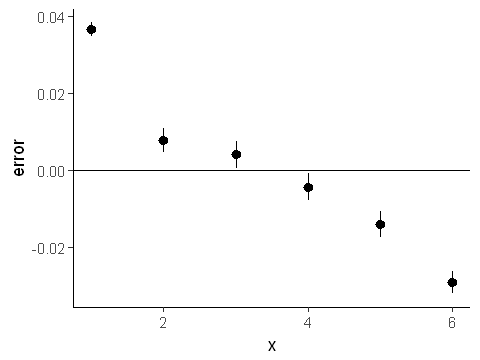

In [11]:
options(repr.plot.width=4, repr.plot.height=3)
fitted  %>% 
    mutate(error = obs - subjectPred)  %>% 
    ggplot(aes(x, error)) +
    stat_summary(fun.data=mean_se) +
    geom_hline(yintercept=0) +
    theme_classic()

The end result of this is that when we average the predictions, the model ends up predicting a much steeper almost linear function, and fails to recover the original data generating function. It has overfit the random noise in a biased way due to its ability to only account for increasing patterns.

### Would having more observations per subject help?

I've made the point that one cause of this problem is the relatively low number of observations per subject. Let's test this idea and see if the bias will disappear if we had more observations. Here's a function for the entire process, and we'll vary the number of observations.

In [12]:
modelFunction <- function(nObs, nSubj, sds, a=1, b=1.5, c=1) {
    # Prep the data. Generate parameters from each subjects from a normal distribution with sd=sd
    data <- expand.grid(x=x, subject=1:nSubj, nObs = nObs)
    data$a <- rnorm(n=nrow(data), mean=a, sd=sds[1])
    data$b <- rnorm(n=nrow(data), mean=b, sd=sds[2])
    data$c <- rnorm(n=nrow(data), mean=c, sd=sds[3])
    data$y <- data$a/(data$b+exp(-data$c*data$x))
    
    # generate data for each subject
    data <- data  %>% 
        group_by(x, subject)  %>% 
        mutate(obs = draw_samples(y, nObs))
    
    # get overall fit
    overall.fit <- optim(c(a,b,c), errorFunction, obs=data$obs, x=data$x)
    data$overallPred <- myPredict(overall.fit$par, data$x)

    # Fit parameters of the logistic function for every subject and extract them
    fittedPars <- data  %>% 
        group_by(subject)  %>% 
        nest(-subject)  %>%
        mutate(fit = map(data, ~ try(optim(par=c(1,1.5,1), fn = errorFunction, obs = .$obs, x=.$x))),
               pars = map(fit, ~ .$par))  %>% 
        select(-fit)

    # Get final predictions for each subject
    fitted <- fittedPars  %>% 
        mutate(subjectPred = map2(data, pars, ~ myPredict(.y, .x$x)))  %>% 
        unnest(data, subjectPred)

    # Calculate the bias
    bias <- fitted  %>%
        group_by(x)  %>% 
        summarise(subjError = mean(obs - subjectPred),
                  overallError = mean(obs - overallPred))
    return(bias)
}

In [13]:
# Calculate the error for different number of observations
set.seed(19882)
bias <- data.frame(nObs = seq(15,105,15))
bias <- bias  %>% 
    group_by(nObs)  %>% 
    do({modelFunction(.$nObs, 2000, c(0,0,0))})

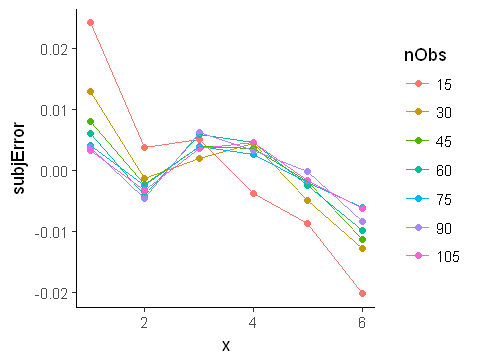

In [14]:
bias  %>% 
    ungroup()  %>% 
    mutate(nObs = as.factor(nObs))  %>% 
    ggplot(aes(x, subjError, color=nObs)) +
    geom_point() +
    geom_line() +
    theme_classic()

Increasing the number of observations definitely helps, thought it never really eliminates the problem. Increasing the number of observations reduced the noise in the obesrved responses, which reduces the bias problem discussed above. In the absence of more obesrvations, however, I'll have to content with fitting the overall data instead. I've thought about using a Bayesian hierarchical estimation, which can help with cases like this by "shrinking" - it imposes a distribution over subject parameters that would minimize the overfitting. Unfortunately, this is not feasible for the model I'm working in, which takes a long time to estimate even as is.

Fortunately, after fitting my model to the averaged data, the problem disappears, as in the simulated example above. I guess that is that. 

![image.png](https://i.imgur.com/3EB4B1a.png)